In [1]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from modules.md_c_interface import launch_simulation, launch_on_doe

from time import time, sleep

from modules.md_utils import complementaire # utils
from modules.md_utils import plot_crystal, plot_2d_simu # plotting
from modules.md_utils import process_results

## Introduction 
Ions should be selected amongst the ones available [here](../md2_notebook_resources/available_ion.png).

As for the parameters, a lots of them are available. You can see them all in [1](../md2_notebook_resources/table_key_description_1.png), [2](../md2_notebook_resources/table_key_description_2.png) and [3](../md2_notebook_resources/table_key_description_3.png).

For simplicity reasons, only a few are available in the following algorithms : ion, ionE, Tset, ionT, ionP, tau, n, dt, dtv and i1.

Which should be given for example like :


## Interest

Understanding how energy absorption, reaction probability and output angle $\phi$ and $\theta$,change with:
- incoming energy;
- collision angle.

In the end, it would be necessary to compare it for various particle types (mass, charge, size, degrees of freedom etc.) in order to have a comprehensive approach of the issue. 

Also, the **type of the surface** we collide with can change. The MD-code already proposes a *SI* surface (which is the most common one). However, in the end, it would be good to be able to add *Al*.

Eventually a study of the **evolution of the surface** could be done : the law governing the output energy, angle and reaction probability ought to change with the **state of the surface**.

## Experience plan

Draw a 3D-plan of experience (on *ionE*, *ionT*). Everything else is kept equals. The thermostat temperature is choosen to be $300$ K (temperature of the neutral gas in the chamber). The azimutal angle is for a first study kept equal to 0.

Note : the simulation in the DSMC code are 2D. The azimutal angle does not make sense in regards to this code. However, it is important to either verify that is does not change the dynamic of the ion or average over many azimutal angle (which would be the most rigorous approach but also the longer one).

For each of those values, we will compute the output polar angle and the ouput energy. 

Also, we are interested in the ionization energy (cf. [wiki - Iodine](https://en.wikipedia.org/wiki/Iodine)). Let's say we launch a ion $[I^-]$. We want to know the probability for it to lose its additional electron and exits the crystal as a neutral atom. 

We see for example, that the first ionization energy for iodine is for an energy of **1008.4** kJ/mol (I did not find for $[I^-]$, but let's say for now it is the same, even though it is not). This amounts to an external energy of :  .

So if the external potential energy grows higher than this number, we can consider the ion lost it electron.

Issue one : we can not simulate $[I]$ apparenty - it does not work (like the particle goes trough the crystal and that's it).

### Notice

One of the issue we have is that Iodine is very massive (127u) while Si is only 28u. Thus, Iodine manages to come in the crystal and never leaves. 

What should be done instead is having Molybdene (95u). However, we can not really change it in the code as it is hard coded and all.

Thus, what we we'll do is maintain the "ratio" :
- Ratio $m_{molyb}/m_{si} = 3.4$
- Ratio $m_{I}/m_{Ar, simu} = 3.4$

Thus, $m_{Ar, simu}  = 37$ u roughly.

In [2]:
speed_range = [0, 25000]# possible speed range that we are interested into
polar_angle_range = [0, 90] # in degree

# converting 

def convert_to_ev(energy_per_mol): # from J/mol -> energy for one particle 
    return energy_per_mol/(1.6e-19*6.02e23)

energy_first_ionization = convert_to_ev(1008.4e3)

### Available particles

In [3]:
colors = {
    'Si':'gray',
    'Ar':'darkviolet',
    'I':'violet',
    'Kr':'lightskyblue',
    'Xe':'dodgerblue',
    'CF3':'red'
}
radii = {
    'Si': 1.11, # Angstrom
    'Ar' : 1.06,
    'I' : 1.98,
    'Kr': 2.02,
    'Xe': 2.17,
    'CF3': 1
}

### Simulations parameters

- We start with *Argon* $[Ar]$, which was modified in the code to behave like *Iodine* $[I]$. 

In [4]:
ion = 'Ar'
test_id = 'doe_1'
name = '../md2_results/test_{}_{}'.format(ion, test_id)
    
params = {
    '-ion' : ion,
    '-ionE' : 10, # eV - input energy for the ion
    '-Tset' : 300, # K - thermostat temp
    '-ionT' : 20, # Degree - phi incident - polar angle
    '-ionP' : 0, # Degree - theta incident - azimutal angle
    '-tau' : 0.01, # s3
    '-n' : 5000, # nb time steps
    '-dt' : 1.e-3, # time step, in ps
    '-i1' : 1, # number of ions launched
    '-ionCOMr' : '0.0 0.0 14.0', # ion center of mass
    # '-iui' : 1.e-3, # ion update interval
}

flags = ['+dtv']

### DOE

In [5]:
from pyDOE2 import lhs

In [6]:
def convert(doe, min_val, max_val):
    return min_val + doe*(max_val-min_val)

In [7]:
keys = ['-ionE', '-ionT', '-ionP']
dimension = 3
doe = lhs(dimension, samples = 1000)

e = 1.6e-19
mass = 127*1.6e-27 # Iodine roughly
ratio_mass = 3.4
v_min, v_max = 10, 3e4 # from 1 to 30k m/s
nrj_ev_min, nrj_ev_max = 0.5*mass*v_min**2/(e*ratio_mass), 0.5*mass*v_max**2/(e*ratio_mass)

doe[:,0] = convert(doe[:,0], nrj_ev_min, nrj_ev_max) # ion Energy (in eV)
doe[:,1] = convert(doe[:,1], -90., 90.) # ion polar angle in degree (between -pi/2 and pi/2 - -90 and 90)
doe[:,2] = convert(doe[:,2], -180., 180.) # ion azimutal angle in degree (between 0 and 2pi, -180 and 180)

In [8]:
doe[:10]

array([[ 137.70228215,  -34.25200254,  -65.31334141],
       [ 158.66022528,  -18.12584327,  -12.40642884],
       [  37.25188266,  -76.83121846,  177.18207017],
       [  34.8080657 ,   83.86005909,  -71.80961733],
       [ 104.54852171,  -28.42153643,  -66.92758621],
       [  89.641918  ,   83.04824151,  163.16736234],
       [ 116.50083246,   35.71288137, -111.07475827],
       [  72.08877703,  -19.1035071 ,   28.66808825],
       [  86.23794836,  -17.8975113 ,   62.67282982],
       [  86.97306769,   30.11237006,  -34.66141933]])

### Launching simulation

In [ ]:
# launch_simulation(name, params, flags, launches = 1, verbose = True)
launch_on_doe(name, params, flags, keys = keys, design_of_experiments = doe, clean = True) # actually we are only interested in ionE and ionT

./md2 -oc cfg/####.cfg -ion Ar -ionE 111.88091469915634 -Tset 300 -ionT -61.208410118413994 -ionP -79.46745009175085 -tau 0.01 -n 5000 -dt 0.001 -i1 1 -ionCOMr 0.0 0.0 14.0 -oi ion/0306.ion +dtv  > log &
./md2 -oc cfg/####.cfg -ion Ar -ionE 1.0715841308479903 -Tset 300 -ionT -29.66716471952116 -ionP -71.45371397988868 -tau 0.01 -n 5000 -dt 0.001 -i1 1 -ionCOMr 0.0 0.0 14.0 -oi ion/0307.ion +dtv  > log &
./md2 -oc cfg/####.cfg -ion Ar -ionE 108.2092302039681 -Tset 300 -ionT 85.2271531531928 -ionP 118.17734654999805 -tau 0.01 -n 5000 -dt 0.001 -i1 1 -ionCOMr 0.0 0.0 14.0 -oi ion/0308.ion +dtv  > log &
./md2 -oc cfg/####.cfg -ion Ar -ionE 134.4681936770235 -Tset 300 -ionT 45.22104269120197 -ionP 14.25502320402785 -tau 0.01 -n 5000 -dt 0.001 -i1 1 -ionCOMr 0.0 0.0 14.0 -oi ion/0309.ion +dtv  > log &
./md2 -oc cfg/####.cfg -ion Ar -ionE 0.9881124476875718 -Tset 300 -ionT -51.20709052218076 -ionP 157.0479074068324 -tau 0.01 -n 5000 -dt 0.001 -i1 1 -ionCOMr 0.0 0.0 14.0 -oi ion/0310.ion +dtv 

## Processing results 
The simulation can take a little time even though the previous cell is marked as completed. You should wait one or two minutes (and reload *results* if you see that all data was not yet written to disk).

In [9]:
ions_dict = {
    'low_memory' : True,
    'crystal_height' : 12, # Angstrom
}

results = process_results(Path.cwd()/'md2_sources'/name, process_log = False, args_ions = ions_dict) # 10 ~ angstrom

In [10]:
results.ion.get_output_angles();

Angle - azimutal angle (θ)- polar angle (φ)
0883.ion : θ = nan ; φ = nan
0172.ion : θ = nan ; φ = nan
0070.ion : θ = 8.3e+01 ; φ = 5e+01
0796.ion : θ = nan ; φ = nan
0262.ion : θ = nan ; φ = nan
0628.ion : θ = nan ; φ = nan
0722.ion : θ = nan ; φ = nan
0160.ion : θ = nan ; φ = nan
0585.ion : θ = nan ; φ = nan
0396.ion : θ = nan ; φ = nan
0025.ion : θ = 8.3e+01 ; φ = 6.5e+01
0176.ion : θ = nan ; φ = nan
0392.ion : θ = 8.9e+01 ; φ = 5.3e+01
0419.ion : θ = 3.3e+01 ; φ = 2.6e+01
0458.ion : θ = nan ; φ = nan
0459.ion : θ = nan ; φ = nan
0085.ion : θ = nan ; φ = nan
0760.ion : θ = nan ; φ = nan
0046.ion : θ = nan ; φ = nan
0468.ion : θ = nan ; φ = nan
0450.ion : θ = 9e+01 ; φ = 7.1e+01
0121.ion : θ = 6.8e+01 ; φ = -1.2e+01
0074.ion : θ = nan ; φ = nan
0171.ion : θ = nan ; φ = nan
0187.ion : θ = nan ; φ = nan
0908.ion : θ = nan ; φ = nan
0177.ion : θ = 5.9 ; φ = -2.8
0639.ion : θ = nan ; φ = nan
0041.ion : θ = nan ; φ = nan
0755.ion : θ = nan ; φ = nan
0042.ion : θ = 5.7e+01 ; φ = -2.2e+01
01

Impact time : 0.035 ps.


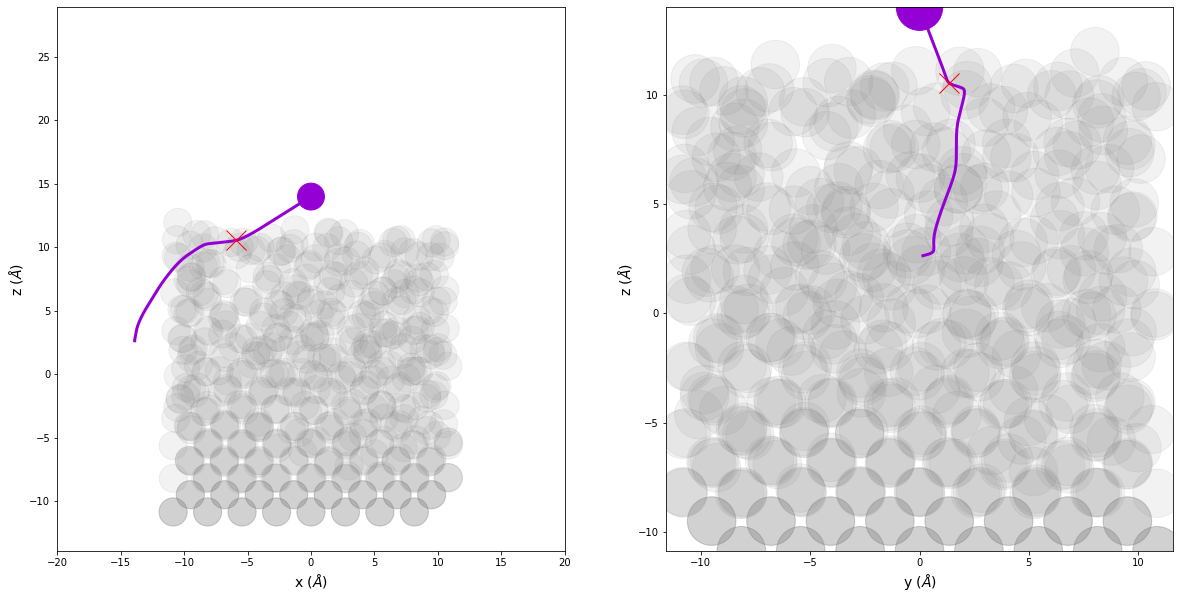

In [11]:
results.ion.load('0001.ion')
plot_2d_simu(ion, results.ion.current_df, results.crystal.dataframes['0000.cfg'], radii, colors, start = True, xlim = (-20, 20), ylim = (-15, 30))

In [12]:
df = results.ion.current_df

<AxesSubplot:xlabel='t', ylabel='ke/E_i'>

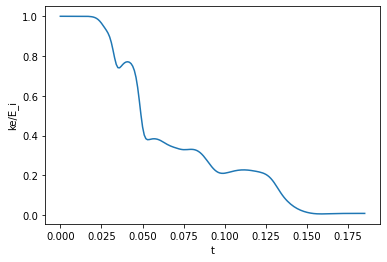

In [13]:
sns.lineplot(data = df, x = 't', y = 'ke/E_i')

<AxesSubplot:xlabel='t', ylabel='ipe'>

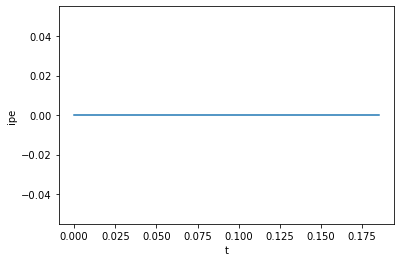

In [14]:
sns.lineplot(data = df, x = 't', y = 'ipe')

<AxesSubplot:xlabel='t', ylabel='epe'>

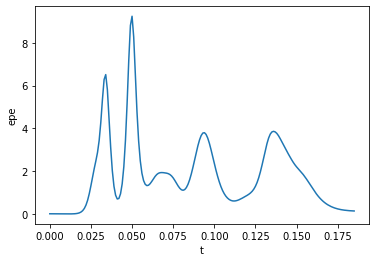

In [15]:
sns.lineplot(data = df, x = 't', y = 'epe') # external potential energy